In [68]:
import numpy as np
from collections import OrderedDict as od
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
import matplotlib
import csv
from matplotlib import path

try:
    from astropy.convolution import Gaussian2DKernel, convolve
    astro_smooth = True
except ImportError as IE:
    astro_smooth = False

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import match_coordinates_sky as coords
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles

#from astropy.units import cds
#cds.enable()

from astropy.cosmology import LambdaCDM, FlatLambdaCDM

from PIL import Image

from astropy.io import ascii
from astropy.io.ascii import masked
from astropy.table import Table

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from numpy import polyfit
from astropy.time import Time

#import uncertainties as unc  
#import uncertainties.unumpy as unp
import time

#import kcorrect.response

In [4]:
manga_file = fits.open(r"C:\Users\paiaa\Blanton Lab\mnsa-0.3.0.fits")
hdu_manga = manga_file[2]
manga_data = hdu_manga.data


wise_file = fits.open(r"WISE variations/WISE_statistics_2arcsec_sigradec.fits")
wise_hdu = wise_file[1]
hdu = wise_hdu.data
wise_hdu.header

jiyan_file = fits.open(r"WISE variations/jiyan-agn-0.3.2.fits")
jiyan_hdu = jiyan_file[1]
jhdu = jiyan_hdu.data
#jiyan_hdu.header

In [18]:
w1_vega, w2_vega = 2.680448504503577, 3.3161984371892177

In [19]:
hdu_manga.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  174 / width of table in bytes                        
NAXIS2  =                11273 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   10 / number of fields in each row                   
TTYPE1  = 'plateifu'           / label for field   1                            
TFORM1  = '12A     '           / data format of field: ASCII Character          
TTYPE2  = 'do_sps  '           / label for field   2                            
TFORM2  = 'L       '           / data format of field: 1-byte LOGICAL           
TTYPE3  = 'hemi    '        

In [20]:
x1 = hdu['expected var all epochs (mags)']
y1 = hdu['observed var']

y2 = hdu['expected var (errors)']
x2 = hdu['expected var (mags)']


w12 = hdu['mean W1 per epoch']-hdu['mean W2 per epoch']
w12_var = np.nanvar(w12, axis = 1)
x3 = w12_var
y3 = hdu['observed var']


w2_mean = np.nanmean(hdu['mean W2 per epoch'], axis = 1)
w1_mean = np.nanmean(hdu['mean W1 per epoch'], axis = 1)
x4 = w1_mean - w2_mean
y4 = hdu['observed var']

plateifu = hdu['plateifu']

In [21]:
def epoch2epoch_varW2(x1, y1, plateifu):  
    # color by w1-w2
    w2 = np.nanmean(hdu['mean W2 per epoch'], axis = 1)
    w1 = np.nanmean(hdu['mean W1 per epoch'], axis = 1)

    #for x1 and y1 (getting rid of 0, -9999, np.nan)
    mask = ~((x1 == -9999.) | (y1 == -9999.) | (w1 == -9999.) | (w2 == -9999.))
    x1, y1, w1,w2, plateifu = x1[mask], y1[mask], w1[mask], w2[mask], plateifu[mask]
    w12 = w1 - w2
    mask1 = ~((np.isnan(x1)) | (np.isnan(y1)))
    x1, y1, w12, plateifu = x1[mask1], y1[mask1], w12[mask1], plateifu[mask1]
    mask2 = ~((x1 == 0.) | (y1 == 0.))
    x1,y1, w12, plateifu = x1[mask2], y1[mask2], w12[mask2], plateifu[mask2]

    #getting rid of anomalous W1-W2
    mask3 = ~((w12 > 100) | (w12 < -100))
    X1, Y1, W12, plateifu = x1[mask3], y1[mask3], w12[mask3], plateifu[mask3]

    #W1-W2 colour cut
    #rd = kcorrect.response.ResponseDict()
    #rd.load_response('wise_w2')
    #w2_vega = rd['wise_w2'].vega2ab
    #rd.load_response('wise_w1')
    #w1_vega = rd['wise_w1'].vega2ab

    #w1_vega, w2_vega = 2.680448504503577, 3.3161984371892177
    #Assef et. al. (2012) cut = -0.18 AB mags. Converting to Vega mags with m_ab = m_vega + m_delta
    cut = -0.18 - (w1_vega - w2_vega)  #(w1_vega - w2_vega) = m_delta

    red_mask = ( W12 > cut)
    X1_red, Y1_red, W12_red, red_plateifu = X1[red_mask], Y1[red_mask], W12[red_mask], plateifu[red_mask]

    X1_blue, Y1_blue, W12_blue, blue_plateifu = X1[~red_mask], Y1[~red_mask], W12[~red_mask], plateifu[~red_mask]
    
    return X1, Y1, W12, plateifu, X1_red, Y1_red, W12_red, red_plateifu, X1_blue, Y1_blue, W12_blue, blue_plateifu

In [22]:
X1, Y1, W12, plateifu, X1_red, Y1_red, W12_red, red_plateifu, X1_blue, Y1_blue, W12_blue, blue_plateifu = epoch2epoch_varW2(x1, y1, plateifu)

In [23]:
def per_epoch_var_W2(x2, y2):
    #for x2 and y2
    x2test = x2.reshape(-1)
    y2test = y2.reshape(-1)

    xx2 = np.array([])
    yy2 = np.array([])

    mask = ~((np.isnan(x2test)) | (np.isnan(y2test)))
    xx2, yy2 = x2test[mask], y2test[mask]
    xxx2, yyy2 = xx2[xx2 != -9999.], yy2[yy2 != -9999.]
    mask2 = ~((xxx2 == 0.) | (yyy2==0.))
    X2,Y2 = xxx2[mask2], yyy2[mask2]
    
    return X2, Y2

In [24]:
X2, Y2 = per_epoch_var_W2(x2, y2)

In [25]:
def contour(x,y):
    H, xedges, yedges = np.histogram2d((x),(y), bins=(50,40))
    xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])

    # Smooth the contours (if astropy is installed)
    if astro_smooth:
        kernel = Gaussian2DKernel(x_stddev = 1.)
        H=convolve(H,kernel)
    return xmesh, ymesh, H.T

Xc1, Yc1, Z1 = contour(X1, Y1)
Xc2, Yc2, Z2 = contour(np.log10(X2), np.log10(Y2))

NameError: name 'clevelsf' is not defined

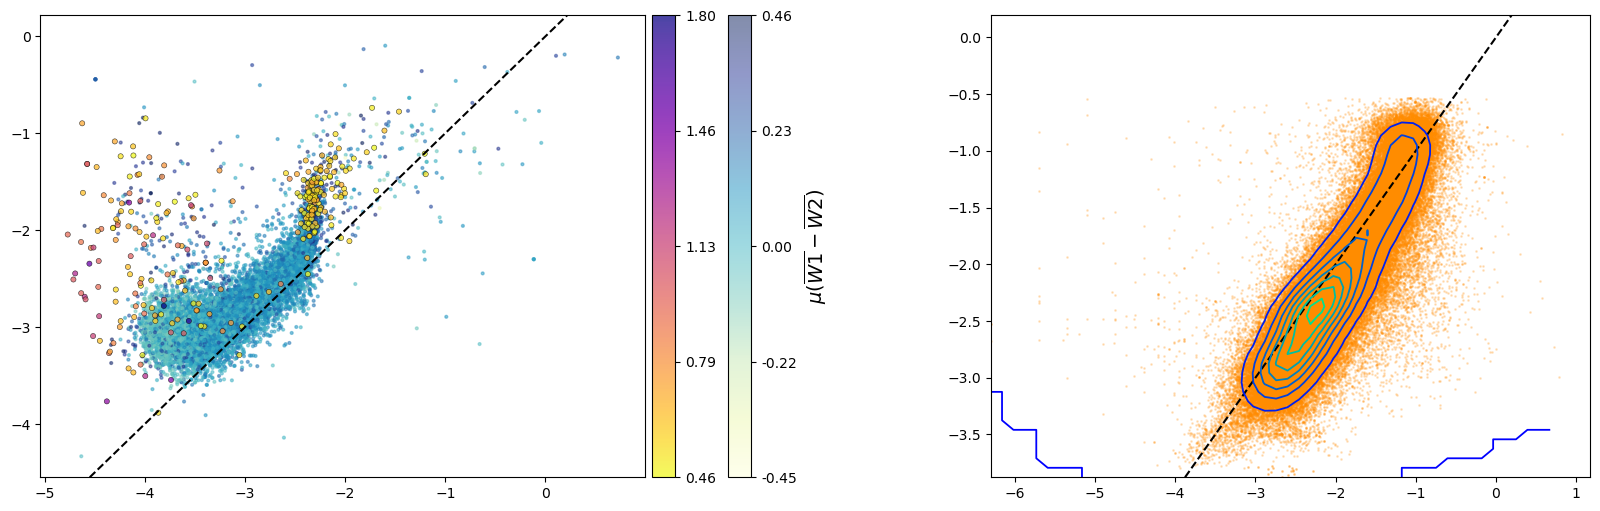

In [26]:
fig, ax = plt.subplots(figsize = (20,6), ncols = 2,  gridspec_kw={'width_ratios': [1.35, 1]})
axa, axb = ax

#colorbar decimal place format
fmt = tkr.FormatStrFormatter("%.2f")

#plot 1
#axa.set_facecolor("gainsboro")
plot1_blue = axa.scatter(np.log10(X1_blue), np.log10(Y1_blue), c = W12_blue, cmap = 'YlGnBu', alpha = 0.5, s = 4)
plot1_red = axa.scatter(np.log10(X1_red), np.log10(Y1_red), c = W12_red, edgecolors = 'black', lw = 0.4, cmap = 'plasma_r', alpha = 0.75, s = 14)
axa.axline((0, 0), slope= 1, color = 'black', linestyle = 'dashed', label = 'y = x')
#axa.axline((-0.5, -2), slope= 0, color = 'gray', linestyle = 'dashed', label = 'AGN cutoff')
#clevels = axa.contour(Xc1, Yc1, Z1, lw=.2, cmap='winter')
#axa.fill_between(np.linspace(-4.8, 0,100), -2*np.ones(100)+ 0, -2*np.ones(100) +3*np.ones(100), alpha=0.075, label = 'AGN')
ca_blue = fig.colorbar(plot1_blue, ax=axa, orientation='vertical', pad=0.01, ticks=np.linspace(W12_blue.min(), W12_blue.max(), 5), format = fmt)
ca_red = fig.colorbar(plot1_red, ax=axa, orientation='vertical', pad=0.01,fraction=0.1, ticks=np.linspace(W12_red.min(), W12_red.max(), 5), format = fmt)
ca_blue.set_label(label = r'$\mu(\overline{W1}-\overline{W2})$',size=14)
#plot 2
axb.scatter(np.log10(X2), np.log10(Y2), color = 'darkorange', alpha = 0.2, s = 1)
axb.axline((0, 0), slope = 1, color = 'black', linestyle = 'dashed', label = 'y = x')
clevels = axb.contour(Xc2, Yc2, Z2, linewidths=1.3, cmap='winter')
#clevelsf = plt.contourf(Xc2, Yc2, Z2, lw=.5, cmap='winter')
fig.colorbar(clevelsf, ax=axb, orientation='vertical')


axa.legend()

axa.set_xlim(-4.5, -0.75)
axa.set_ylim(-4.25, 0)

axa.set_xlabel(r'expected $\log{Var(W2)}$',  fontsize=14)
axa.set_ylabel(r'observed $\log{Var(W2)}$',  fontsize=14)

axb.legend()

axb.set_xlim(-4, 0)
axb.set_ylim(-4, -0.25)

axb.set_xlabel(r'expected $\log{\sigma^2_{W2}}$ per epoch',  fontsize=14)
axb.set_ylabel(r'expected $\log{Var(W2)}$ per epoch',  fontsize=14)


#plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\\' + 'MaNGA_WISE_variations_colorcut_sigradec.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

### Plotting light curves

In [27]:
#calculating fluxes for W1 and W2, first calculate conversion factor mag_to_Jy
#redshift = manga_data['redshift']
#cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
#luminosity_distance = cosmo.luminosity_distance(redshift)
#luminosity_distance = luminosity_distance.to(u.pc)
#abmag_dist = 10 * u.pc

#mag_to_Jy = np.square(abmag_dist/luminosity_distance)

In [32]:
def lightcurves(w12, plateifu):
    #rd = kcorrect.response.ResponseDict()
    #rd.load_response('wise_w2')
    #w2_vega = rd['wise_w2'].vega2ab
    #rd.load_response('wise_w1')
    #w1_vega = rd['wise_w1'].vega2ab

    #w1_vega, w2_vega = 2.680448504503577, 3.3161984371892177
    #Assef et. al. (2012) cut = -0.18 AB mags. Converting to Vega mags with m_ab = m_vega + m_delta
    cut = -0.18 - (w1_vega - w2_vega)  #(w1_vega - w2_vega) = m_delta
    
    wise1 = hdu['mean W1 per epoch']
    wise2 = hdu['mean W2 per epoch']

    dates1 = hdu['epoch date']
    dates2 = hdu['epoch date']

    mask1 = ~((wise1 == -9999.) | (np.isnan(wise1)))
    mask2 = ~((wise2 == -9999.) | (np.isnan(wise2)))



    w1 = []
    d1 = []
    for i, mask in enumerate(mask1):
        w1.append(wise1[i][mask])
        d1.append(dates1[i][mask])

    w2 = []
    d2 = []
    for i, mask in enumerate(mask2):
        w2.append(wise2[i][mask])
        d2.append(dates2[i][mask])

    datetime1 = []
    for array in d1:
        datetime1.append(pd.to_datetime(array + 2400000.5, origin='julian', unit='D'))

    datetime2 = []
    for array in d2:
        datetime2.append(pd.to_datetime(array + 2400000.5, origin='julian', unit='D'))
        
    #converting from vega mags to AB mags
    w1ab = []
    w2ab = []

    for i in w1:
        w1ab.append(i + rd['wise_w1'].vega2ab) #w1_vega)

    for i in w2:
        w2ab.append(i + rd['wise_w2'].vega2ab) #w2_vega)

    #converting from AB mags to flux
    w1Jy = []
    w2Jy = []

    for i, array in enumerate(w1ab):
        flux = 3631 * (10**(-0.4 * array))
        w1Jy.append(flux)

    for i, array in enumerate(w2ab):
        flux = 3631 * (10**(-0.4 * array))
        w2Jy.append(flux)

    red_mask = ( W12 > cut)
    red_plateifu = plateifu[red_mask]
    W12_red = w12[red_mask]
    #sort dictionary from least red (above assef cut) to most red
    W12_plateifu = dict(zip(red_plateifu, W12_red))
    sorted_w12_red = dict(sorted(W12_plateifu.items(), key=lambda item: item[1]))
    sorted_plateifu = sorted_w12_red.keys()

    indices = np.array([])
    for i in sorted_plateifu:
        index = np.where(hdu['plateifu'] == i)[0]
        indices = np.append(indices, index)
    indices = indices.astype('int64')
    return w1Jy, datetime1, w2Jy, datetime2, indices, sorted_plateifu

In [33]:
w1Jy, datetime1, w2Jy, datetime2, indices, sorted_pifu = lightcurves(W12, plateifu)

NameError: name 'rd' is not defined

In [ ]:
#plt.plot(datetime1[indices[100]], w1Jy[indices[100]])

### Ji & Yan color cut

In [34]:
def JiYan_cut(x, y, w12, plateifu):
    #rd = kcorrect.response.ResponseDict()
    #rd.load_response('wise_w2')
    #w2_vega = rd['wise_w2'].vega2ab
    #rd.load_response('wise_w1')
    #w1_vega = rd['wise_w1'].vega2ab

#w1_vega, w2_vega = 2.680448504503577, 3.3161984371892177
#Assef et. al. (2012) cut = -0.18 AB mags. Converting to Vega mags with m_ab = m_vega + m_delta
    cut = -0.18 - (w1_vega - w2_vega)  #(w1_vega - w2_vega) = m_delta

    red_mask = ( w12 > cut)
    
    #calculate blue objects
    blue_objs = plateifu[~red_mask]
    W12_blue = w12[~red_mask]
    p1b = np.array([])
    p3b = np.array([])
    for i in blue_objs:
        p1b = np.append(p1b, jhdu['p1'][jhdu['plateifu'] == i])
        p3b = np.append(p3b, jhdu['p3'][jhdu['plateifu'] == i])
        
    nan_mask = ~((p1b == -9999.) | (p3b == -9999.))
    p1b, p3b, blue_objs, W12_blue = p1b[nan_mask], p3b[nan_mask], blue_objs[nan_mask], W12_blue[nan_mask]
    
    
    red_objs = plateifu[red_mask]
    W12_red = w12[red_mask]
    p1r = np.array([])
    p3r = np.array([])
    for i in red_objs:
        p1r = np.append(p1r, jhdu['p1'][jhdu['plateifu'] == i])
        p3r = np.append(p3r, jhdu['p3'][jhdu['plateifu'] == i])
    nan_mask = ~((p1r == -9999.) | (p3r == -9999.))
    p1r, p3r, red_objs, W12_red = p1r[nan_mask], p3r[nan_mask], red_objs[nan_mask], W12_red[nan_mask]
    
    return p1b, p3b, W12_blue, p1r, p3r, W12_red

In [35]:
p1bJY, p3bJY, W12_blueJY, p1rJY, p3rJY, W12_redJY = JiYan_cut(X1, Y1, W12, plateifu)

Text(0.5, 0, '$P1$')

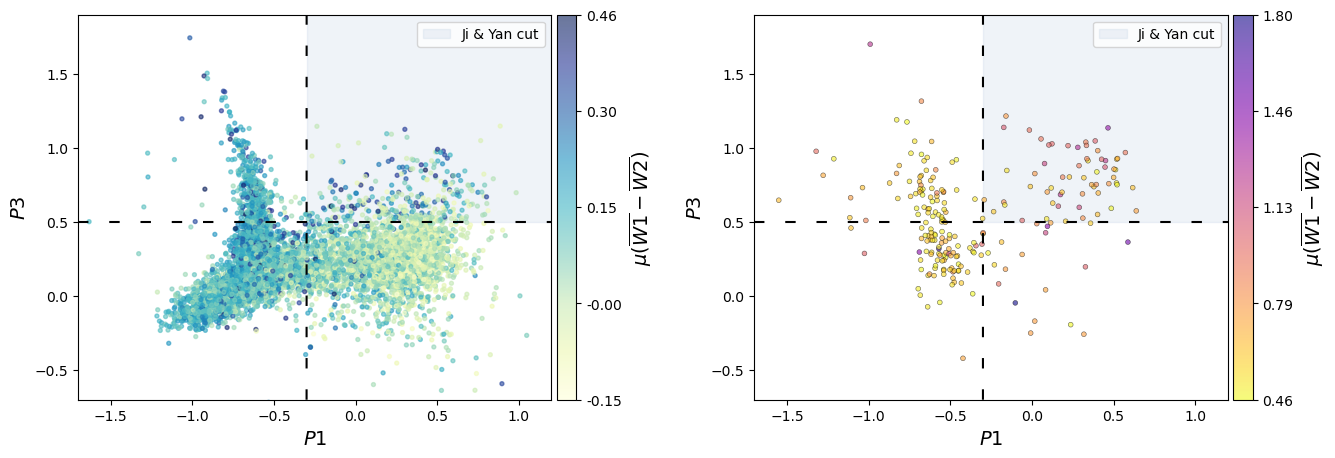

In [36]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,5))
axa, axb = ax

axa.fill((-0.3, -0.3, 1.3, 1.3),(1.9,0.5, 0.5, 1.9), color = 'lightsteelblue', alpha = 0.2, label = 'Ji & Yan cut')
plot1 = axa.scatter(p1bJY, p3bJY, c = W12_blueJY, cmap = 'YlGnBu', s = 8, alpha = 0.6)
axa.axline((0, 0.5), slope= 0, color = 'black', linestyle = (0, (5, 10)))
axa.axline((-0.3, 0), slope= 10000, color = 'black', ls = (0, (5, 10)))
ca_blue = fig.colorbar(plot1, ax=axa, orientation='vertical', pad=0.01, ticks=np.linspace(W12_blueJY.min(), W12_blueJY.max(), 5), format = fmt)
ca_blue.set_label(label = r'$\mu(\overline{W1}-\overline{W2})$',size=14)

axa.set_ylim(-0.7,1.9)
axa.set_xlim(-1.7, 1.2)

axa.legend()

axa.set_ylabel('$P3$',  fontsize=14)
axa.set_xlabel('$P1$',  fontsize=14)

axb.fill((-0.3, -0.3, 1.3, 1.3),(1.9,0.5, 0.5, 1.9), color = 'lightsteelblue', alpha = 0.2, label = 'Ji & Yan cut')
plot2 = axb.scatter(p1rJY, p3rJY, c = W12_redJY, cmap = 'plasma_r', edgecolors = 'black', lw = 0.4, s = 12, alpha = 0.6)
axb.axline((0, 0.5), slope= 0, color = 'black', linestyle = (0, (5, 10)))
axb.axline((-0.3, 0), slope= 10000, color = 'black', ls = (0, (5, 10)))
ca_red = fig.colorbar(plot2, ax=axb, orientation='vertical', pad=0.01, ticks=np.linspace(W12_redJY.min(), W12_redJY.max(), 5), format = fmt)
ca_red.set_label(label = r'$\mu(\overline{W1}-\overline{W2})$',size=14)

axb.set_ylim(-0.7,1.9)
axb.set_xlim(-1.7, 1.2)

axb.legend()

axb.set_ylabel('$P3$',  fontsize=14)
axb.set_xlabel('$P1$',  fontsize=14)

#plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\plots\\' + 'MaNGA_WISE_JiYan_colorcut_sigradec.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [37]:
#literally take all objects in the spur and plot P1 vs P3 of them => if most of them are ACTUALLY variable then theyll e im JiYan cut
#plot histogram of no# vs W1-W2 and look at shape of the distribution
#plot W2 vs sigma^2 and that should correlate along y = x because fainter objects => more error, make a cut on W2 and discard all the corresponding sigma^2 objects in the spur plot

In [38]:
#Lyu and Reike: read cited papers 17, 317, 271, 291

In [39]:
def spur_JiYan(X1_red, Y1_red, X1_blue, Y1_blue, W12_red, W12_blue, red_plateifu, blue_plateifu):
    
    cut_mask_r = ((np.log10(X1_red) < -2.0) & (np.log10(X1_red) > -2.5)) & ((np.log10(Y1_red) < -1.0) & (np.log10(Y1_red) > -2.2))
    X_spur_r = X1_red[cut_mask_r]
    Y_spur_r = Y1_red[cut_mask_r]
    W12_spur_r = W12_red[cut_mask_r]
    spur_plateifu_r = red_plateifu[cut_mask_r]
    
    cut_mask_b = ((np.log10(X1_blue) < -2.0) & (np.log10(X1_blue) > -2.5)) & ((np.log10(Y1_blue) < -1.0) & (np.log10(Y1_blue) > -2.2))
    X_spur_b = X1_blue[cut_mask_b]
    Y_spur_b = Y1_blue[cut_mask_b]
    W12_spur_b = W12_blue[cut_mask_b]
    spur_plateifu_b = blue_plateifu[cut_mask_b]
    
    p1r_spur = np.array([])
    p3r_spur = np.array([])
    for i in spur_plateifu_r:
        p1r_spur = np.append(p1r_spur, jhdu['p1'][jhdu['plateifu'] == i])
        p3r_spur = np.append(p3r_spur, jhdu['p3'][jhdu['plateifu'] == i])
        
    p1b_spur = np.array([])
    p3b_spur = np.array([])
    for i in spur_plateifu_b:
        p1b_spur = np.append(p1b_spur, jhdu['p1'][jhdu['plateifu'] == i])
        p3b_spur = np.append(p3b_spur, jhdu['p3'][jhdu['plateifu'] == i])
    
    return X_spur_r, Y_spur_r, W12_spur_r, spur_plateifu_r, p1r_spur, p3r_spur, X_spur_b, Y_spur_b, W12_spur_b, spur_plateifu_b, p1b_spur, p3b_spur

In [40]:
X_spur_r, Y_spur_r, W12_spur_r, spur_plateifu_r, p1r_spur, p3r_spur, X_spur_b, Y_spur_b, W12_spur_b, spur_plateifu_b, p1b_spur, p3b_spur = spur_JiYan(X1_red, Y1_red, X1_blue, Y1_blue, W12_red, W12_blue, red_plateifu, blue_plateifu)

In [41]:
W12_spur = np.append(W12_spur_r, W12_spur_b)

In [42]:
W12_spur.shape

(888,)

Text(0.5, 0, '$W1-W2$ (Vega mags)')

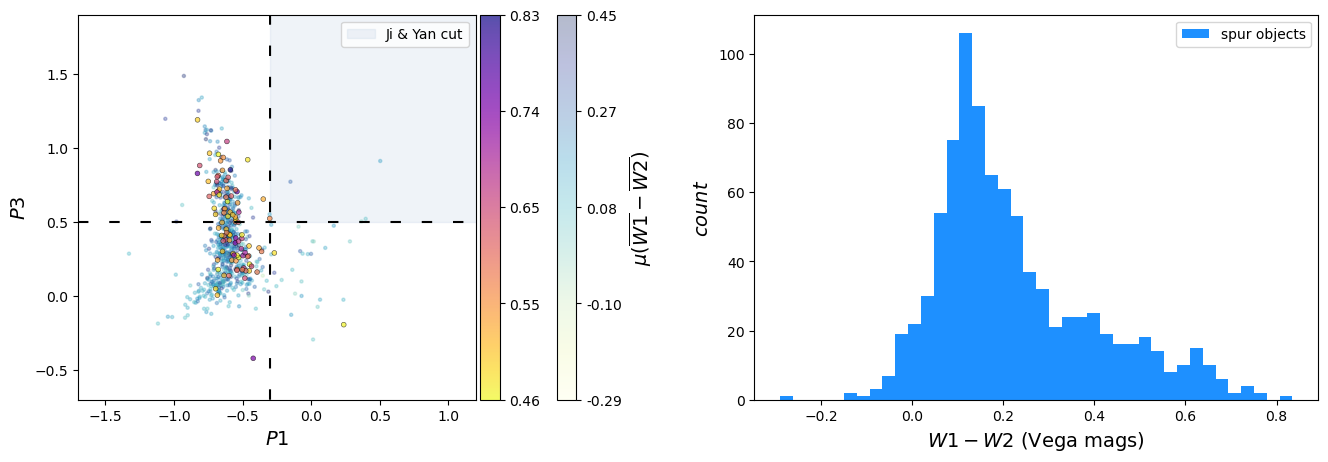

In [43]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,5))
axa, axb = ax

axa.fill((-0.3, -0.3, 1.3, 1.3),(1.9,0.5, 0.5, 1.9), color = 'lightsteelblue', alpha = 0.2, label = 'Ji & Yan cut')
plot1 = axa.scatter(p1b_spur, p3b_spur, c = W12_spur_b, cmap = 'YlGnBu', s = 5, alpha = 0.3)

plot2 = axa.scatter(p1r_spur, p3r_spur, c = W12_spur_r, cmap = 'plasma_r', edgecolors = 'black', lw = 0.4, s = 12, alpha = 0.7)
axa.axline((0, 0.5), slope= 0, color = 'black', linestyle = (0, (5, 10)))
axa.axline((-0.3, 0), slope= 10000, color = 'black', ls = (0, (5, 10)))
ca_blue = fig.colorbar(plot1, ax=axa, orientation='vertical', pad=0.01, ticks=np.linspace(W12_spur_b.min(), W12_spur_b.max(), 5), format = fmt)
ca_blue.set_label(label = r'$\mu(\overline{W1}-\overline{W2})$',size=14)

ca_red = fig.colorbar(plot2, ax=axa, orientation='vertical', pad=0.01, ticks=np.linspace(W12_spur_r.min(), W12_spur_r.max(), 5), format = fmt)


axa.set_ylim(-0.7,1.9)
axa.set_xlim(-1.7, 1.2)

axa.legend()

axa.set_ylabel('$P3$',  fontsize=14)
axa.set_xlabel('$P1$',  fontsize=14)

plot2 = axb.hist(W12_spur, color = 'dodgerblue', bins = 40, label = 'spur objects');

axb.legend()

axb.set_ylabel('$count$',  fontsize=14)
axb.set_xlabel('$W1-W2$ (Vega mags)',  fontsize=14)

#plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\plots\\' + 'MaNGA_WISE_JiYan_spur_sigradec.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [46]:
def W2_vs_err_varW2():
    x1 = hdu['expected var all epochs (mags)']
    y1 = hdu['expected var all epochs (errors)']
    plateifu = hdu['plateifu']
    w1 = np.array([])
    w2 = np.array([])
    
    for pifu in plateifu:
        
        w1temp = hdu[hdu['plateifu'] == pifu]['mean W1 per epoch']
        w2temp = hdu[hdu['plateifu'] == pifu]['mean W2 per epoch']
        
        mask = ~((w1temp == -9999.) | (w2temp == -9999.))
        w1temp, w2temp = w1temp[mask], w2temp[mask]
        
        w1 = np.append(w1, np.nanmean(w1temp))
        w2 = np.append(w2, np.nanmean(w2temp))


    #for x1 and y1 (getting rid of 0, -9999, np.nan)
    mask = ~((x1 == -9999.) | (y1 == -9999.) | (w1 == -9999.) | (w2 == -9999.))
    x1, y1, w1,w2, plateifu = x1[mask], y1[mask], w1[mask], w2[mask], plateifu[mask]
    w12 = w1-w2
    mask1 = ~((np.isnan(x1)) | (np.isnan(y1)))
    x1, y1, w2, w12, plateifu = x1[mask1], y1[mask1], w2[mask1], w12[mask1], plateifu[mask1]
    mask2 = ~((x1 == 0.) | (y1 == 0.))
    x1,y1, w2, w12, plateifu = x1[mask2], y1[mask2], w2[mask2], w12[mask2], plateifu[mask2]

    #getting rid of anomalous W1-W2
    mask3 = ~((w2 > 100) | (w2 < -100))
    X1, Y1, W2, W12, plateifu = x1[mask3], y1[mask3], w2[mask3], w12[mask3], plateifu[mask3]
    
    
    #W1-W2 colour cut
    #rd = kcorrect.response.ResponseDict()
    #rd.load_response('wise_w2')
    #w2_vega = rd['wise_w2'].vega2ab
    #rd.load_response('wise_w1')
    #w1_vega = rd['wise_w1'].vega2ab

    #w1_vega, w2_vega = 2.680448504503577, 3.3161984371892177
    #Assef et. al. (2012) cut = -0.18 AB mags. Converting to Vega mags with m_ab = m_vega + m_delta
    cut = -0.18 - (w1_vega - w2_vega)  #(w1_vega - w2_vega) = m_delta

    red_mask = ( W12 > cut)
    X1_red, Y1_red, W2r, W12_red, red_plateifu = X1[red_mask], Y1[red_mask], W2[red_mask], W12[red_mask], plateifu[red_mask]

    X1_blue, Y1_blue, W2b, W12_blue, blue_plateifu = X1[~red_mask], Y1[~red_mask], W2[~red_mask], W12[~red_mask], plateifu[~red_mask]
    
    return X1, Y1, W2, W2r, W2b, W12, plateifu, X1_red, Y1_red, W12_red, red_plateifu, X1_blue, Y1_blue, W12_blue, blue_plateifu

In [47]:
x1w2, y1w2, W2, W2r, W2b, w12, pifu, x1e, y1r, w12r, rpifu, x1b, y1b, w12b, bpifu = W2_vs_err_varW2()

C:\Users\paiaa\AppData\Local\Temp\ipykernel_19748\304204057.py:16: RuntimeWarning: Mean of empty slice
  w1 = np.append(w1, np.nanmean(w1temp))
C:\Users\paiaa\AppData\Local\Temp\ipykernel_19748\304204057.py:17: RuntimeWarning: Mean of empty slice
  w2 = np.append(w2, np.nanmean(w2temp))


In [48]:
xcw2, ycw2, zw2 = contour(np.log10(x1w2), W2)

NameError: name 'clevelsf2' is not defined

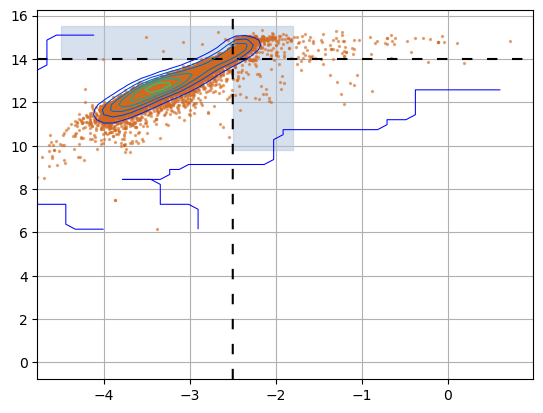

In [49]:
fig, ax = plt.subplots(ncols = 1)
axa = ax
axa.set_axisbelow(True)
plt.grid()


axa.fill((-2.5, -2.5, -1.8, -1.8),(15.5,9.8, 9.8, 15.5), color = 'lightsteelblue', alpha = 0.5, label = 'discarded points')

axa.fill((-4.5, -4.5, -2.5, -2.5),(15.5,14, 14, 15.5), color = 'lightsteelblue', alpha = 0.5)

axa.scatter(np.log10(x1w2), W2, s = 2, c = 'chocolate', alpha = 0.5)
axa.axline((-2.5, 0), slope= 100000, color = 'black', linestyle = (0, (5, 7)))
axa.axline((0, 14), slope= 0, color = 'black', linestyle = (0, (5, 7)))
clevels = axa.contour(xcw2, ycw2, zw2, linewidths=0.75, cmap='winter')
#clevelsf2 = plt.contourf(xcw2, ycw2, zw2, lw=.5, cmap='winter')
fig.colorbar(clevelsf2, ax=axa, orientation='vertical')

axa.set_xlim(-4.5, -1.8)
axa.set_ylim(9.75, 15.5)

axa.legend()

axa.set_xlabel(r'expected $\log{Var(W2)}$',  fontsize=14)
axa.set_ylabel(r'$W2$ (Vega mags)',  fontsize=14)

#plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\plots\\' + 'MaNGA_WISE_W2_vs_VarW2.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [50]:
#making a cut in expected log Var(W2) = -2.5 and W2 = 14

In [51]:
w2cut = ((np.log10(x1w2) <= -2.5) & (W2 < 14.))
#rd = kcorrect.response.ResponseDict()
#rd.load_response('wise_w2')
#w2_vega = rd['wise_w2'].vega2ab
#rd.load_response('wise_w1')
#w1_vega = rd['wise_w1'].vega2ab

In [52]:
x1w2cut = x1w2[w2cut]
y1w2cut = y1w2[w2cut]
w12cut = w12[w2cut]

cut = -0.18 - (w1_vega - w2_vega)
redmask = w12cut > cut
x1w2_cut_r, y1w2_cut_r, w12_cut_r = x1w2cut[redmask], y1w2cut[redmask], w12cut[redmask]
x1w2_cut_b, y1w2_cut_b, w12_cut_b = x1w2cut[~redmask], y1w2cut[~redmask], w12cut[~redmask]

(-4.25, 0.0)

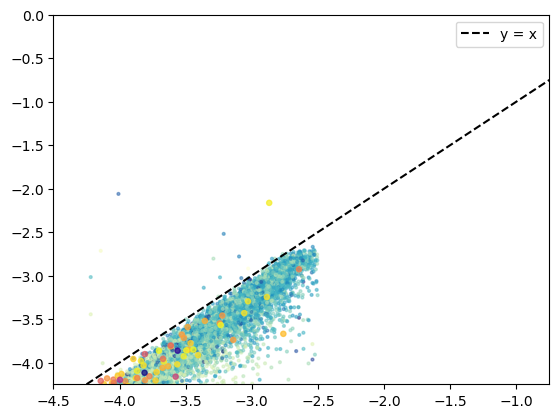

In [53]:
fig, ax = plt.subplots(ncols = 1)
axa = ax


axa.scatter(np.log10(x1w2_cut_b), np.log10(y1w2_cut_b), c = w12_cut_b, cmap = 'YlGnBu', alpha = 0.5, s = 4)
axa.scatter(np.log10(x1w2_cut_r), np.log10(y1w2_cut_r), c = w12_cut_r, cmap = 'plasma_r', alpha = 0.75, s = 14)
axa.axline((0, 0), slope= 1, color = 'black', linestyle = 'dashed', label = 'y = x')

axa.legend()

axa.set_xlim(-4.5, -0.75)
axa.set_ylim(-4.25, 0)


In [54]:
cut = ((np.log10(X1) < -2.5) & (w2 < 14))

NameError: name 'w2' is not defined

In [55]:
#df = pd.read_csv('WISE variations\wise_allsky_coadded.csv')

## comparing MNSA WISE colours to WISE catalogue colors

In [94]:
def mnsa_vs_wise(plateifu):
    
    #rd = kcorrect.response.ResponseDict()
    #rd.load_response('wise_w2')
    #w2_vega = rd['wise_w2'].vega2ab
    #rd.load_response('wise_w1')
    #w1_vega = rd['wise_w1'].vega2ab
    
    w1 = np.array([])
    w2 = np.array([])
    w1_mnsa = np.array([])
    w2_mnsa = np.array([])
    
    for pifu in plateifu:
        
        w1temp = hdu[hdu['plateifu'] == pifu]['mean W1 per epoch']
        w2temp = hdu[hdu['plateifu'] == pifu]['mean W2 per epoch']
        
        mask = ~((w1temp == -9999.) | (w2temp == -9999.))
        w1temp, w2temp = w1temp[mask], w2temp[mask]
        
        w1 = np.append(w1, np.nanmean(w1temp))
        w2 = np.append(w2, np.nanmean(w2temp))
        
        w1_mnsa = np.append(w1_mnsa, manga_data[manga_data['plateifu'] == pifu]['maggies'][:, 5])
        w2_mnsa = np.append(w2_mnsa, manga_data[manga_data['plateifu'] == pifu]['maggies'][:, 6])
    
    mask1 = ~((w1 == 0) | (w2 == 0) | (w1_mnsa == 0) | (w2_mnsa == 0))
    w1, w2, w1_mnsa, w2_mnsa = w1[mask1], w2[mask1], w1_mnsa[mask1], w2_mnsa[mask1]
    
    mask2 = ~((w1 == -9999.) | (w2 == -9999.) | (w1_mnsa == -9999.) | (w2_mnsa == -9999.))
    w1, w2, w1_mnsa, w2_mnsa = w1[mask2], w2[mask2], w1_mnsa[mask2], w2_mnsa[mask2]
    #converting w1 and w2 from vega mags to absmag
    w1_ab = w1 + w1_vega
    w2_ab = w2 + w2_vega
    
    return w1_ab, w2_ab, w1_mnsa, w2_mnsa

In [95]:
w1_ab, w2_ab, w1_mnsa, w2_mnsa = mnsa_vs_wise(plateifu)

C:\Users\paiaa\AppData\Local\Temp\ipykernel_19748\1022723224.py:1: RuntimeWarning: invalid value encountered in log10
  np.log10(w2_mnsa).min()


nan

In [100]:
w1 = -2.5 * np.log10(w1_mnsa) 
w2 = -2.5 * np.log10(w2_mnsa)

C:\Users\paiaa\AppData\Local\Temp\ipykernel_19748\2139083364.py:2: RuntimeWarning: invalid value encountered in log10
  w2 = -2.5 * np.log10(w2_mnsa)


Text(0.5, 0, '$W1$ (WISE)')

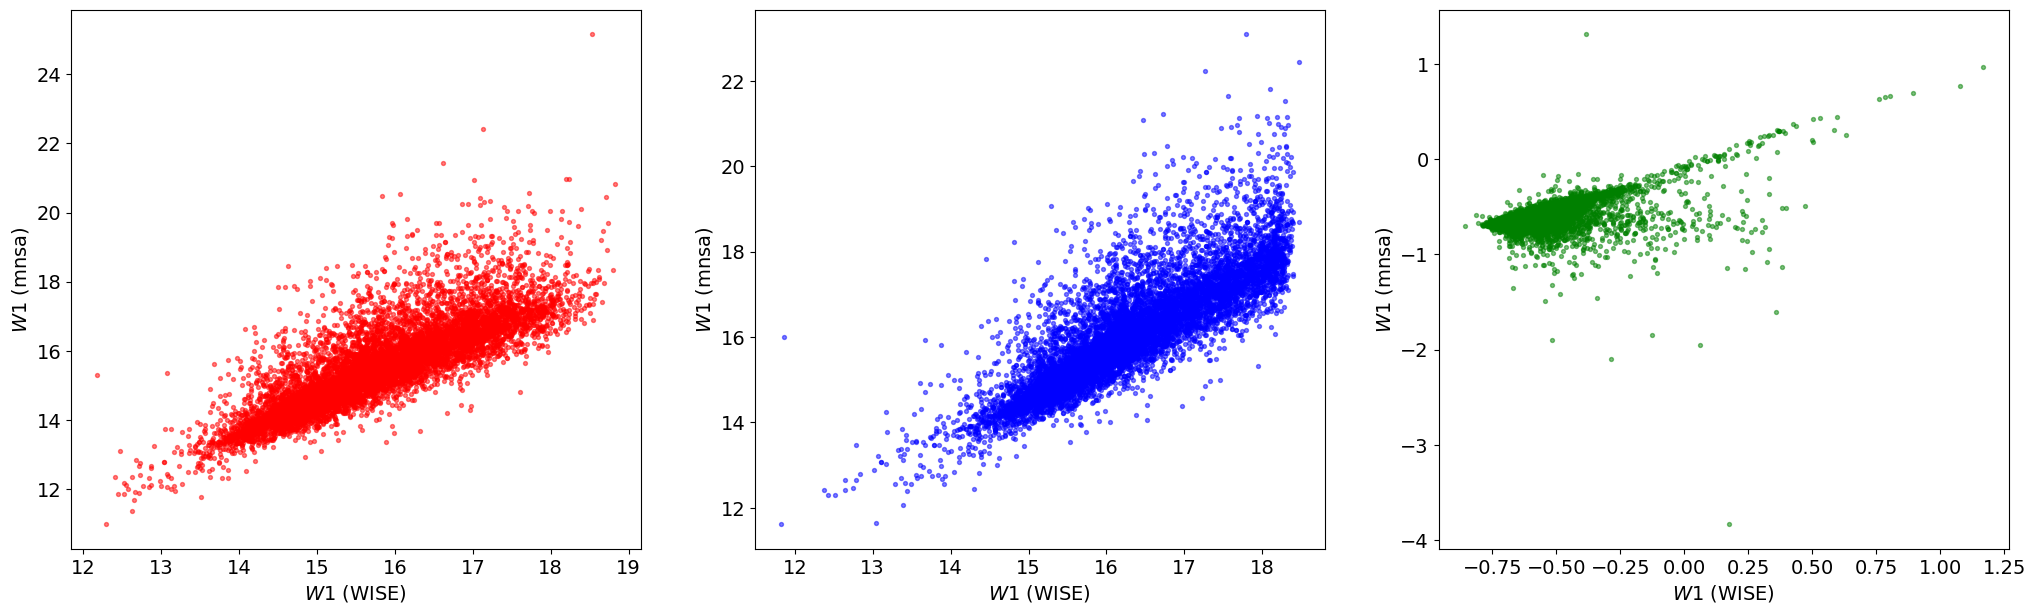

In [106]:
plt.rcParams['font.size'] = 14
w12_ab = w1_ab - w2_ab
w12 = w1 - w2

fig, ax = plt.subplots(ncols = 3, figsize = (25, 7))
axa, axb, axc = ax

axa.scatter(w1_ab, w1, s = 8, c = 'red', alpha = 0.5)
#axa.axline((0,-36), slope = 1, color = 'black')

#axa.set_xlim(12, 19)
#axa.set_ylim(-0.1, 0.1)
axa.set_ylabel('$W1$ (mnsa)')
axa.set_xlabel('$W1$ (WISE)')

axb.scatter(w2_ab, w2, s = 8, c = 'blue', alpha = 0.5)
#axb.axline((0,-36), slope = 1, color = 'black')

#axb.set_xlim(12, 19)
#axb.set_ylim(-25, -14)
axb.set_ylabel('$W1$ (mnsa)')
axb.set_xlabel('$W1$ (WISE)')

axc.scatter(w12_ab, w12, s = 8, c = 'green', alpha = 0.5)
#axc.axline((0,-0.1), slope = 1, color = 'black')

#axc.set_xlim(-1, 1)
#axc.set_ylim(-1.25, 0.5)
axc.set_ylabel('$W1$ (mnsa)')
axc.set_xlabel('$W1$ (WISE)')

In [59]:
manga_data['absmag'][1,5]

-19.5502

In [60]:
manga_data['absmag'][:, 5].max()

0.0

In [73]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
w1_maggies = manga_data['maggies'][:, 5]
mask = ~((w1_maggies == 0) | (w1_maggies == -9999.))
w1_maggies = w1_maggies[mask]
w1 = -2.5* np.log10(w1_maggies)